In [29]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import plotly.graph_objs as go
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### 1. t-критерий Стьюдента

Реализовать t-критерий Стьюдента для 2 независимых выборок при условии неизвестной дисперсии.

Необходимо считать значение статистики и p_value для разных видов гипотез (двусторонняя, односторонние), а также результат (отвергается нулевая гипотеза или нет).

Сравнить результаты с реализацией в scipy.stats.ttest_ind. 

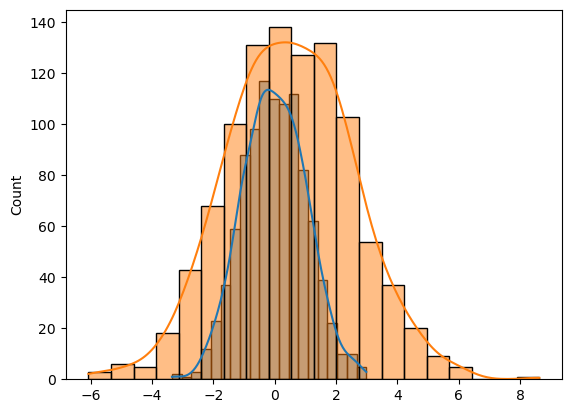

In [87]:
x1 = sps.norm.rvs(loc=0, scale=1, size=1000)
x2 = sps.norm.rvs(loc=0.5, scale=2, size=1000)
mean_1 = x1.mean()
mean_2 = x2.mean()

sns.histplot(x1, bins=20, kde=True)
sns.histplot(x2, bins=20, kde=True);

In [3]:
def ttest(a, b, alternative='two-sided', **kwargs):
    mean_a = a.mean()
    mean_b = b.mean()
    var_a = a.var(ddof=1)
    var_b = b.var(ddof=1)
    n_a = a.shape[0]
    n_b = b.shape[0]
    n = n_a + n_b - 2

    t = (mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)
    p_value = sps.t.cdf(t, n)

    if alternative == 'two-sided':    
        p_value = p_value * 2
    elif alternative == 'greater':
        p_value = 1 - p_value

    return t, p_value


ttest(x1, x2, 'less'), sps.ttest_ind(x1, x2, equal_var=False, alternative='less')

((-1.4815464399568448, 0.06930935191226174),
 Ttest_indResult(statistic=-1.4815464399568448, pvalue=0.06933490303735022))

In [16]:
tests = [
    (0, 0, 1, 1, 'two-sided'),
    (0, 0, 1, 8, 'two-sided'),
    (0, 5, 1, 1, 'two-sided'),
    (0, 5, 1, 8, 'two-sided'),
    (0, 0, 1, 1, 'less'),
    (0, 0, 1, 8, 'less'),
    (0, 5, 1, 1, 'less'),
    (0, 5, 1, 8, 'less'),
    (0, 0, 1, 1, 'greater'),
    (0, 0, 1, 8, 'greater'),
    (0, 5, 1, 1, 'greater'),
    (0, 5, 1, 8, 'greater'),
]
N = 10000
df = pd.DataFrame(columns=['mean_1', 'mean_2', 'var_1', 'var_2', 'my_t', 'true_t', 'my_p', 'true_p', 'type', 'check'])

for params in tests:
    x1 = sps.norm.rvs(loc=params[0], scale=params[2], size=N)
    x2 = sps.norm.rvs(loc=params[1], scale=params[3], size=N)
    type = params[4]
    my_t, my_p = ttest(x1, x2, type)
    true_t, true_p = sps.ttest_ind(x1, x2, equal_var=False, alternative=type)

    df = df.append(pd.Series([
      params[0],
      params[1],
      params[2], 
      params[3],
      my_t, 
      true_t, 
      my_p, 
      true_p, 
      type,
      
      ], index=df.columns), ignore_index=True)

In [17]:
df['check'] = df.apply(
    lambda row: abs(row['my_t'] - row['true_t']) < 0.001 and 
                abs(row['my_p'] - row['true_p']) < 0.001,
    axis=1
    )
df

,mean_1,mean_2,var_1,var_2,my_t,true_t,my_p,true_p,type,check
0,0,0,1,1,-0.375577,-0.375577,0.707235,0.707235,two-sided,True
1,0,0,1,8,-0.321647,-0.321647,0.747724,0.747727,two-sided,True
2,0,5,1,1,-353.614088,-353.614088,0.000000,0.000000,two-sided,True
3,0,5,1,8,-62.321661,-62.321661,0.000000,0.000000,two-sided,True
4,0,0,1,1,0.218949,0.218949,0.586654,0.586654,less,True
5,0,0,1,8,-0.971867,-0.971867,0.165564,0.165570,less,True
6,0,5,1,1,-353.462467,-353.462467,0.000000,0.000000,less,True
7,0,5,1,8,-62.233193,-62.233193,0.000000,0.000000,less,True
8,0,0,1,1,0.452126,0.452126,0.325592,0.325592,greater,True
9,0,0,1,8,0.390473,0.390473,0.348095,0.348097,greater,True


### 2. bootstrap
Реализовать bootstrap для оценки (через доверительные интервалы) медианных и средних значений распределений.

Рассчитать для распределений: нормальное, экспоненциальное, смесь нормальных

In [18]:
def get_bootstrap_sample_indices(sample_size: int, n_samples: int) -> np.ndarray:
    return np.random.randint(0, sample_size, (n_samples, sample_size))

def get_bootstrap_samples(X: np.ndarray, n_samples: int) -> np.ndarray:
    return X[get_bootstrap_sample_indices(len(X), n_samples)]

array([13.90265   , 15.32180619])

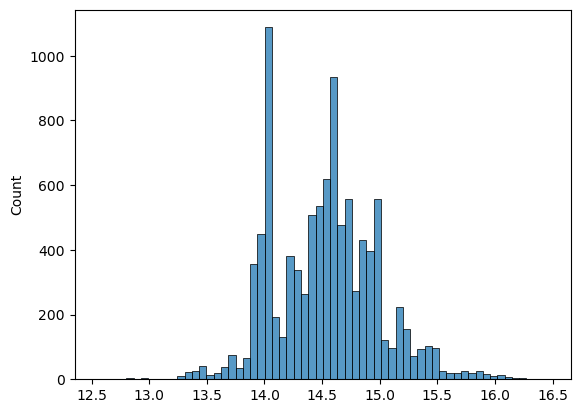

In [27]:
size = 1000
x_a = sps.expon.rvs(loc=4, scale=16, size=size)
X_bootstrap = get_bootstrap_samples(x_a, n_samples=10_000)
metrics_mean = np.median(X_bootstrap, axis=1)
sns.histplot(metrics_mean);

alpha = 0.05
CI = np.percentile(metrics_mean, (alpha * 100, (1 - alpha) * 100))
CI

In [72]:
def bootstrap(x_a, alpha=0.05):
    X_bootstrap = get_bootstrap_samples(x_a, n_samples=10_000)
    metrics_mean = np.mean(X_bootstrap, axis=1)
    metrics_median = np.median(X_bootstrap, axis=1)

    CI_mean = np.percentile(metrics_mean, (alpha * 100, (1 - alpha) * 100))
    CI_median = np.percentile(metrics_median, (alpha * 100, (1 - alpha) * 100))

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    sns.histplot(x_a, ax=axs[0], kde=True)
    sns.histplot(metrics_mean, ax=axs[1], kde=True)
    sns.histplot(metrics_median, ax=axs[2], kde=True)
    
    axs[0].axvline(metrics_mean.mean(), 0, 0.8, c='red')
    axs[0].axvline(np.median(metrics_median), 0, 0.8, c='darkgreen')

    axs[1].axvline(CI_mean[0], 0, 0.4, c='red')
    axs[1].axvline(metrics_mean.mean(), 0, 0.8, c='red')
    axs[1].axvline(CI_mean[1], 0, 0.4, c='red')

    axs[2].axvline(CI_median[0], 0, 0.4, c='darkgreen')
    axs[2].axvline(CI_median.mean(), 0, 0.8, c='darkgreen')
    axs[2].axvline(CI_median[1], 0, 0.4, c='darkgreen')



    axs[0].set_title('Распределение')
    axs[0].set_ylabel('')
    axs[1].set_title(f'Средние, интервал: {CI_mean[0]:.3}, {CI_mean[1]:.3}')
    axs[1].set_ylabel('')
    axs[2].set_title(f'Медианы, интервал: {CI_median[0]:.3}, {CI_median[1]:.3}')
    axs[2].set_ylabel('');


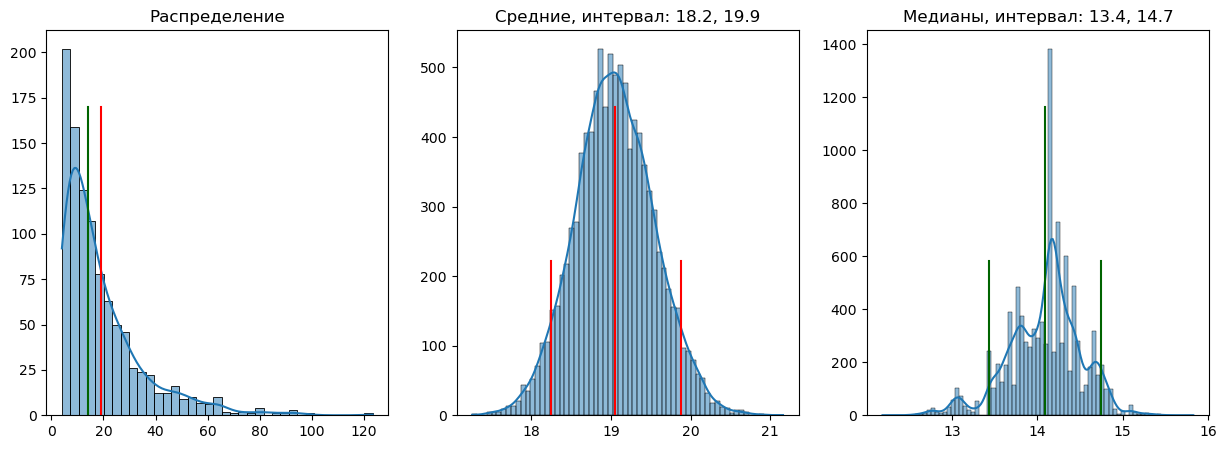

In [73]:
x_a = sps.expon.rvs(loc=4, scale=16, size=1000)
bootstrap(x_a)

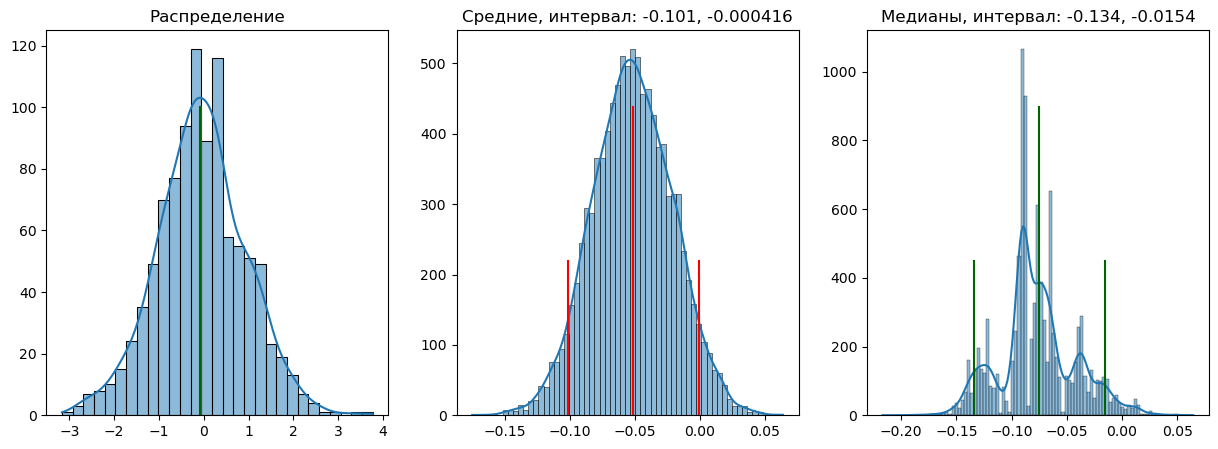

In [74]:
x_a = sps.norm.rvs(loc=0, scale=1, size=1000)
bootstrap(x_a)

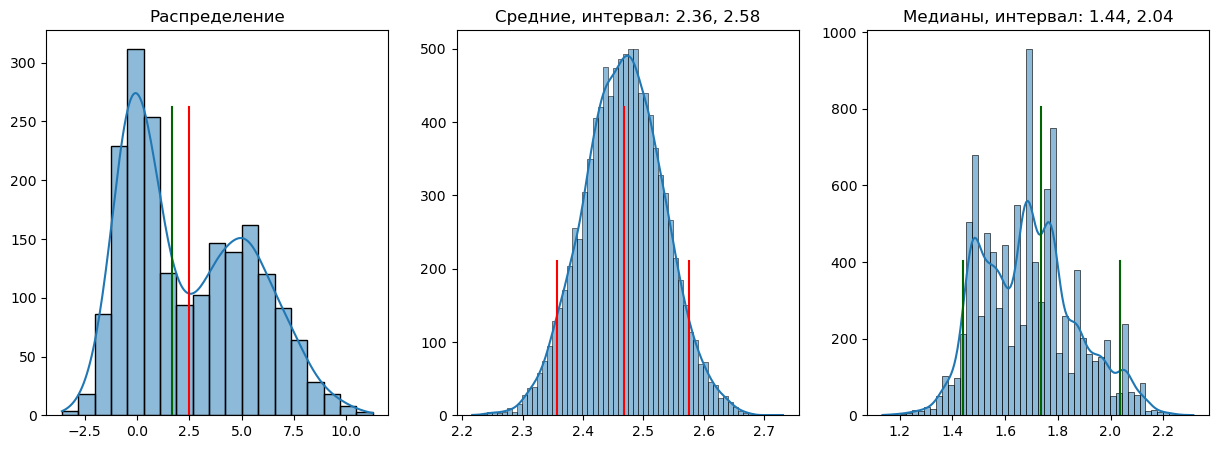

In [84]:
x_a = np.concatenate((sps.norm.rvs(loc=0, scale=1, size=1000), 
                      sps.norm.rvs(loc=5, scale=2, size=1000)))
bootstrap(x_a)

### 3. Манн-Уитни
Рассчитать мощность критерия для t-критерия и критерия Манна-Уитни для разных распределений и разном эффекте. Отдельно изучить случай, когда средние равны, а дисперсии сильно отличаются.

Оценить корректность t-критерия и критерия Манна-Уитни на разных распределениях.

In [135]:
size = 30
n_sample = 1000
p_values = []
for _ in range(n_sample):
    x_a = sps.expon.rvs(loc=1, scale=1, size=size)
    x_b = sps.expon.rvs(loc=1, scale=1, size=size)
    p_values.append(sps.mannwhitneyu(x_a, x_b).pvalue)
p_values = np.array(p_values)

In [144]:
def power_and_correctness(params):
    p_values_t = []
    p_values_mw = []
    size = 100
    n_exp = 10000
    alpha = 0.05

    for i in range(n_exp):
        if params[0] == 'Нормальное распределение':
            x_a = sps.norm.rvs(loc=params[1], scale=params[3], size=size)
            x_b = sps.norm.rvs(loc=params[2], scale=params[4], size=size)
        elif params[0] == 'Экспоненциальное распределение':
            x_a = sps.expon.rvs(loc=1, scale=1, size=size)
            x_b = sps.expon.rvs(loc=1, scale=1, size=size)
        elif params[0] == 'Смесь нормальных распределений':
            x_a = np.append(
                sps.norm.rvs(loc=params[1], scale=params[3], size=size),
                sps.norm.rvs(loc=params[1] + 2, scale=params[3] + 2, size=size)
            )
            x_b = np.append(
                sps.norm.rvs(loc=params[2], scale=params[4], size=size),
                sps.norm.rvs(loc=params[2] + 2, scale=params[4] + 2, size=size),
            )

        p_value_t = sps.ttest_ind(x_a, x_b, equal_var=False).pvalue
        p_values_t.append(p_value_t)

        p_value_mw = sps.mannwhitneyu(x_a, x_b).pvalue
        p_values_mw.append(p_value_mw)
        
    p_values_t = np.array(p_values_t)
    power_t = p_values_t[p_values_t < alpha].shape[0] / p_values_t.shape[0] * 100

    p_values_mw = np.array(p_values_mw)
    power_mw = p_values_mw[p_values_mw < alpha].shape[0] / p_values_mw.shape[0] * 100

    probs_t = []
    probs_mw = []
    x = [0.01 * i for i in range(101)]
    for i in range(101):
        alpha_step = 0.01 * i
        probs_t.append(p_values_t[p_values_t < alpha_step].shape[0] / p_values_t.shape[0])
        probs_mw.append(p_values_mw[p_values_mw < alpha_step].shape[0] / p_values_mw.shape[0])

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    sns.set_style("darkgrid")
    sns.scatterplot(x=x, y=probs_t, ax=axs[0])
    sns.lineplot(x=x, y=x, color='r', ax=axs[0])
    axs[0].set_title(f'T-test, мощность: {power_t:.4}%')

    sns.scatterplot(x=x, y=probs_mw, ax=axs[1])
    sns.lineplot(x=x, y=x, color='r', ax=axs[1]);
    axs[1].set_title(f'Манн-Уитни, мощность: {power_mw:.4}%')



In [ ]:
params = ('Нормальное распределение', 1, 5, 1, 1)
print(f'{params[0]}, среднее: {params[1]}, эффект: {params[2] - params[1]}, дисперсии: {params[3]} и {params[4]}')
power_and_correctness(params)


Нормальное распределение, среднее: 1, эффект: 0, дисперсии: 1 и 10


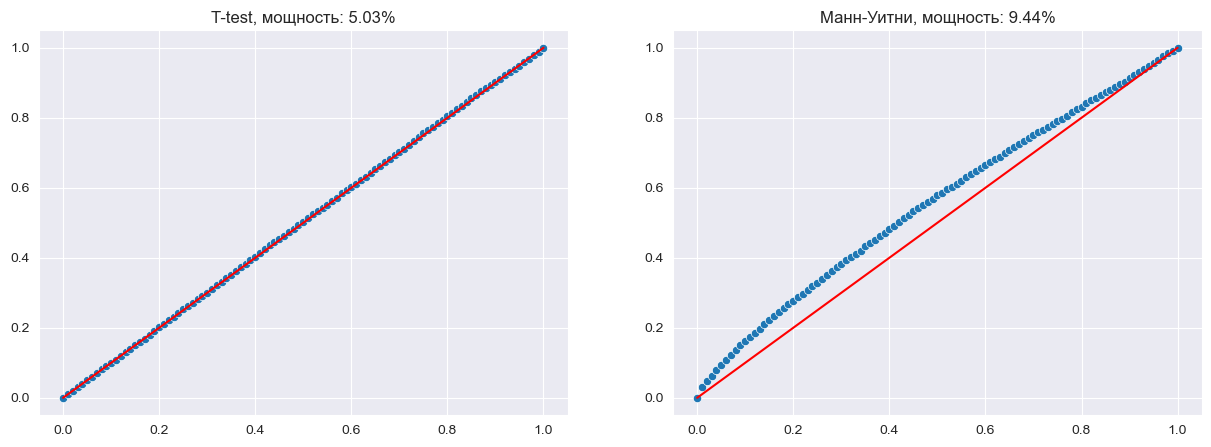

In [145]:
params = ('Нормальное распределение', 1, 1, 1, 10)
print(f'{params[0]}, среднее: {params[1]}, эффект: {params[2] - params[1]}, дисперсии: {params[3]} и {params[4]}')
power_and_correctness(params)


Смесь нормальных распределений, среднее: 1, эффект: 0, дисперсии: 1 и 1


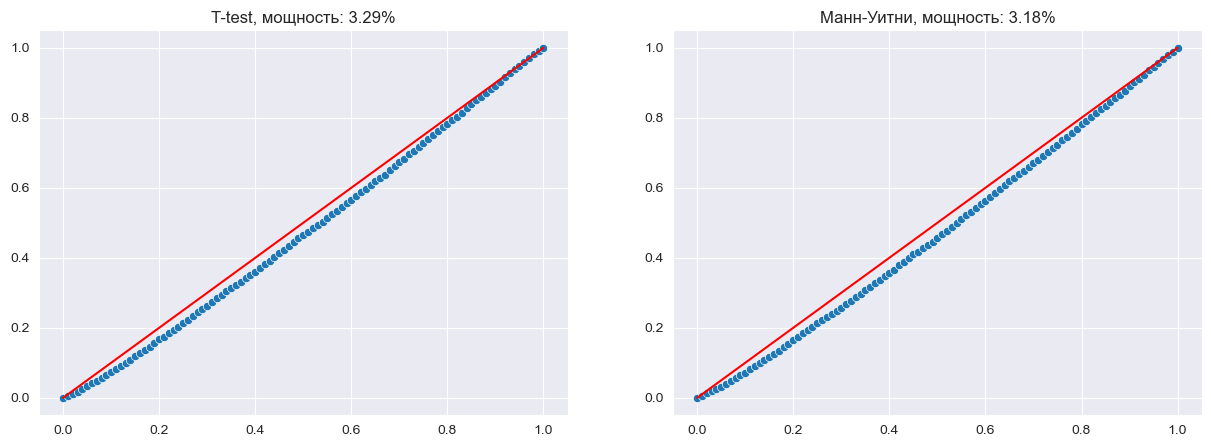

In [142]:
params = ('Смесь нормальных распределений', 1, 1, 1, 1)
print(f'{params[0]}, среднее: {params[1]}, эффект: {params[2] - params[1]}, дисперсии: {params[3]} и {params[4]}')
power_and_correctness(params)

Смесь нормальных распределений, среднее: 1, эффект: 2, дисперсии: 1 и 1


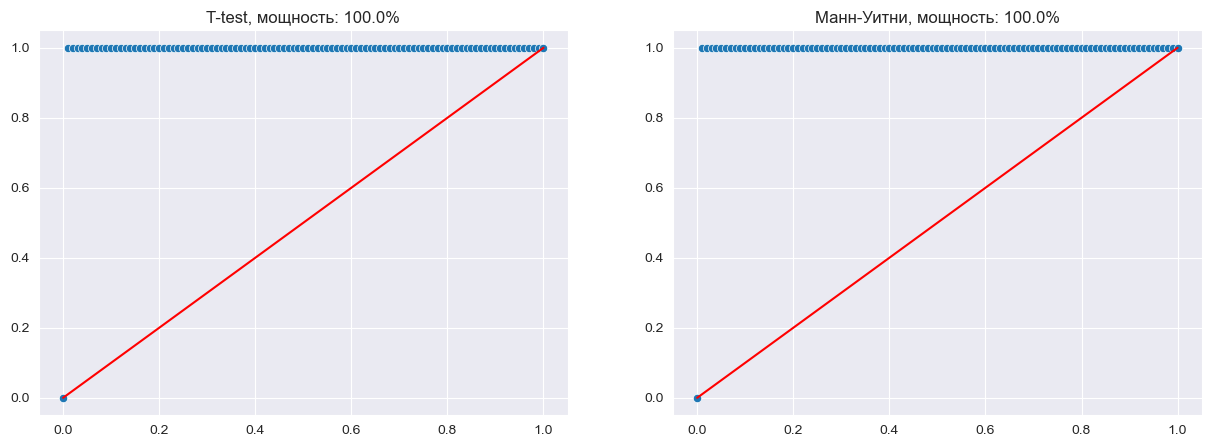

In [143]:
params = ('Смесь нормальных распределений', 1, 3, 1, 1)
print(f'{params[0]}, среднее: {params[1]}, эффект: {params[2] - params[1]}, дисперсии: {params[3]} и {params[4]}')
power_and_correctness(params)

In [130]:
size = 100
effect = 10
n_exp = 10_000
alpha = 0.05

p_values = []
for i in range(n_exp):
    x_a = sps.norm.rvs(loc=10, scale=3, size=size)
    x_b = sps.norm.rvs(loc=10 + effect, scale=3, size=size)
    p_value = sps.ttest_ind(x_a, x_b).pvalue
    p_values.append(p_value)
p_values = np.array(p_values)

p_values[p_values < alpha].shape[0] / p_values.shape[0] * 100

100.0

In [120]:
probs = []
x = [0.01 * i for i in range(101)]
for i in range(101):
    alpha_step = 0.01 * i
    probs.append(p_values[p_values < alpha_step].shape[0] / p_values.shape[0])

<Axes: >

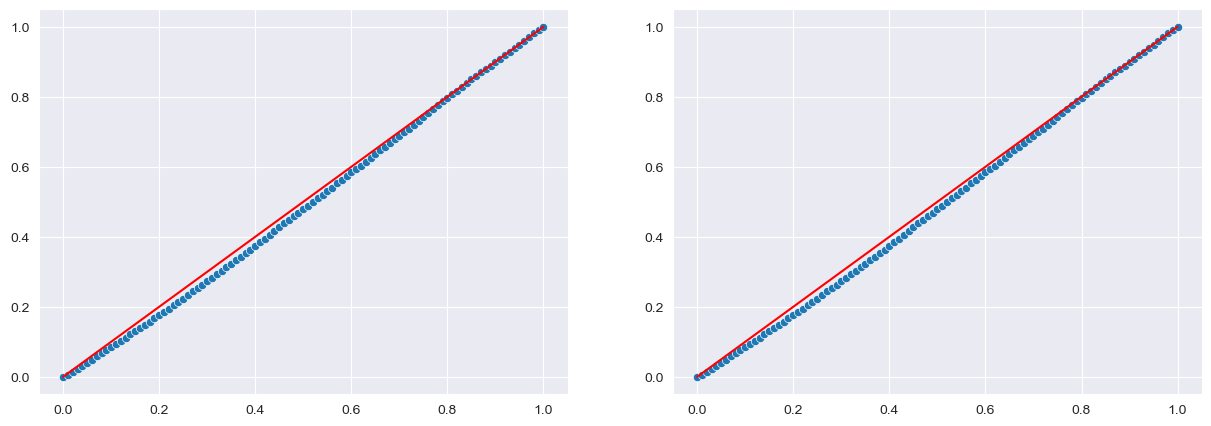

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("darkgrid")
sns.scatterplot(x=x, y=probs, legend='full', ax=axs[0])
sns.lineplot(x=x, y=x, color='r', ax=axs[0])

sns.scatterplot(x=x, y=probs, legend='full', ax=axs[1])
sns.lineplot(x=x, y=x, color='r', ax=axs[1])

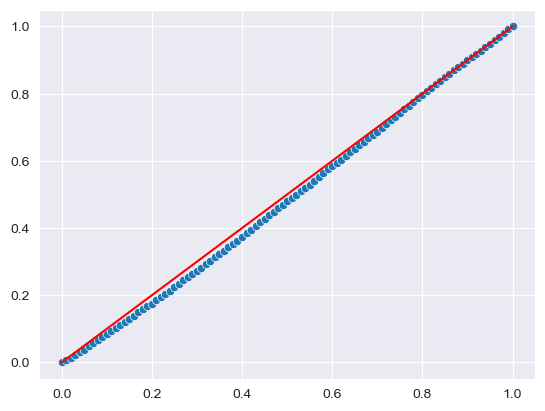

In [115]:
sns.set_style("darkgrid")
sns.scatterplot(x=x, y=probs, legend='full')
sns.lineplot(x=x, y=x, color='r');

In [95]:
fig = go.Figure([go.Scatter(x=x, y=probs, mode="markers", name="p_value"),
                 go.Scatter(x=x, y=x, mode="lines", name="uniform")])
fig.update_layout(height=600, width=600, title="Q-Q plot")